In [6]:
import sys

if 'google.colab' in sys.modules:

    from google.colab import drive
    drive.mount('/content/drive')
    
    COMPETION_DATA_DIR = '/content/drive/MyDrive/input/kaggle/feedback-prize-english-language-learning'

    !pip install tokenizers
    !pip install transformers

    from sklearn.svm import SVR

    train_path = COMPETION_DATA_DIR + '/train.csv'
    test_path = COMPETION_DATA_DIR + '/test.csv'
    sub_path = COMPETION_DATA_DIR + '/sample_submission.csv'
    iter_path = COMPETION_DATA_DIR + '/iterativestratification'
    npy_path = COMPETION_DATA_DIR + '/embedding-ko'

elif 'kaggle_web_client' in sys.modules:

    COMPETION_DATA_DIR = '/kaggle/input'
    sys.path.append('../input/iterativestratification')
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    from cuml.svm import SVR
    import cuml

    train_path = COMPETION_DATA_DIR + '/feedback-prize-english-language-learning/train.csv'
    test_path = COMPETION_DATA_DIR + '/feedback-prize-english-language-learning/test.csv'
    sub_path = COMPETION_DATA_DIR + '/feedback-prize-english-language-learning/sample_submission.csv'
    iter_path = COMPETION_DATA_DIR + '/iterativestratification'
    npy_path = COMPETION_DATA_DIR + '/embedding-ko'

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 26.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 23.2 MB/s 
     |████████████████████████████████| 182 kB 51.4 MB/s 


In [7]:
!pip install readability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35478 sha256=06eed6ae0ae4fefc43be9fb96c9569074268ecd1aea3a931e693b5938bc0ece0
  Stored in directory: /root/.cache/pip/wheels/b9/8b/5a/ba40b81d8e91c7bc1d4226fa51d7b5943d147be122df515c19
Successfully built readability


In [8]:
import readability
import pandas as pd
import re

In [9]:
train = pd.read_csv(train_path)
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [10]:
def data_cleaner(text):
    text = text.strip()
    text = re.sub(r'\n', '', text)
    text = text.lower()
    return text

In [11]:
def calc_readability(text):

    results = readability.getmeasures(text, lang='en')

    return results['readability grades']['ARI']


In [12]:
train['full_text'] = train['full_text'].apply(data_cleaner)
train['readability'] = train['full_text'].apply(calc_readability)
train['words'] = train['full_text'].apply(lambda x: len(x.split()))

In [13]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,readability,words
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129.998750,258
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,264.355364,528
2,00299B378633,"dear, principalif u change the school policy o...",3.0,3.5,3.0,3.0,3.0,2.5,161.781155,319
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,376.070397,721
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,114.772308,232


In [19]:
train.describe(percentiles = [0.01, 0.05, 0.95, 0.99])

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,readability,words
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,216.107997,425.992841
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,97.051566,190.887699
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.755714,14.000000
1%,2.000000,1.550000,2.000000,2.000000,2.000000,2.000000,61.222129,122.100000
5%,2.000000,2.000000,2.500000,2.000000,2.000000,2.000000,92.793281,185.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,201.622103,397.000000
95%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,396.656655,783.000000
99%,4.500000,4.500000,5.000000,4.500000,4.500000,4.500000,557.505750,1090.600000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,624.912385,1250.000000


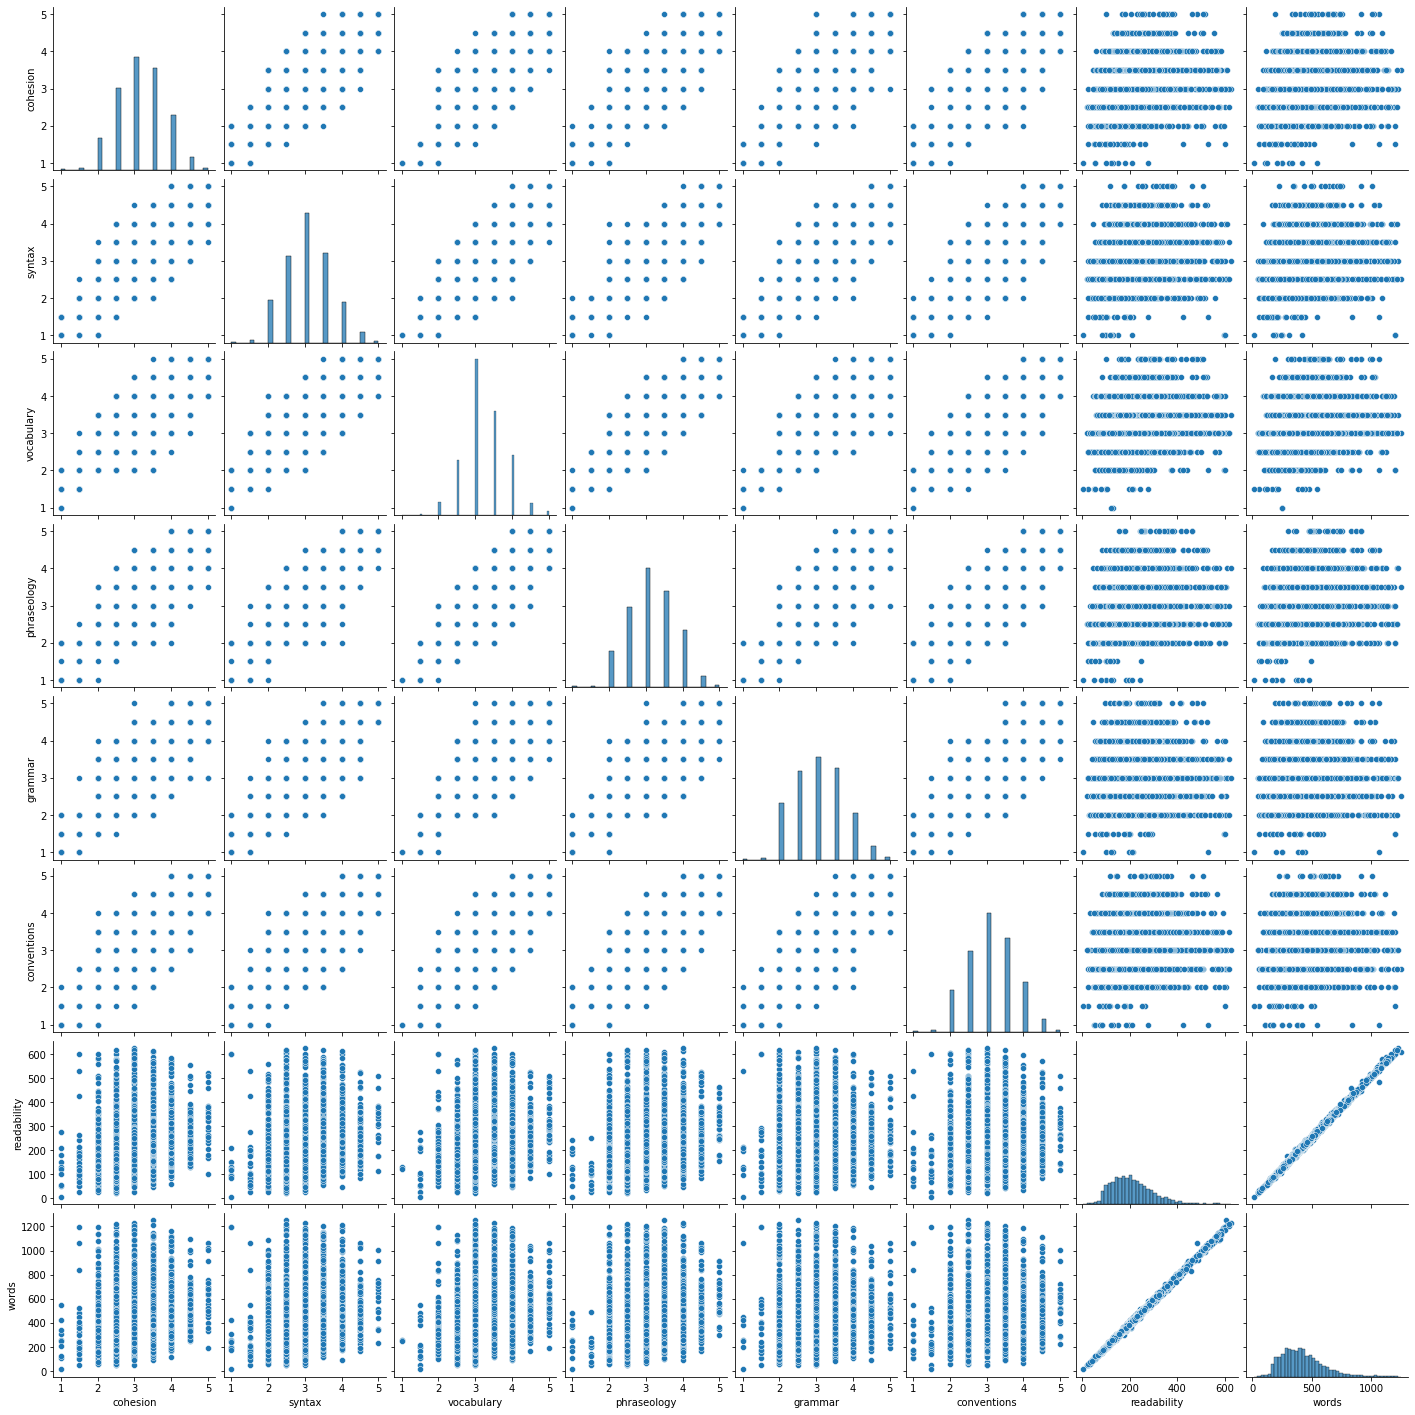

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.pairplot(train)
plt.show()

# Try predicting 'cohesion' using Ridge and other features

In [3]:
from sklearn.linear_model import Ridge

In [15]:
model = Ridge()
model.fit(train[['syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'readability', 'words']], train['cohesion'].values)
 

Ridge()

In [16]:
y_pred = model.predict(train[['syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'readability', 'words']])

In [17]:
model.coef_

array([ 0.23693547,  0.17829258,  0.19786772,  0.0876204 ,  0.19572698,
        0.00201619, -0.00083459])

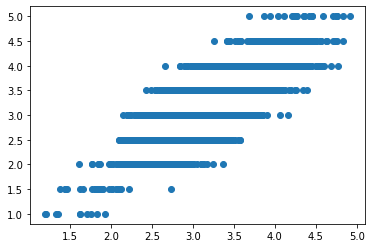

In [18]:
plt.scatter(y_pred, train['cohesion'])